# Companion to Featuring Data [#11] - Clustering Part 1

## k-Means and Choosing the Number of Clusters

Some intro text.


In [42]:
# Import the necessary packages:

import numpy as np
from sklearn import cluster, datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from gap_statistic import OptimalK

from bokeh.plotting import figure, show
from bokeh.models import Span
from bokeh.layouts import gridplot
from bokeh.io import output_notebook

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from prediction_strength import get_prediction_strength

In [43]:
# Load an array of colors for plotting below:
colors = ['#332288', '#88CCEE', '#44AA99', '#117733', '#999933', '#DDCC77', '#CC6677', '#882255', '#AA4499', '#77AADD',
          '#88CCAA']

# Bokeh command to load plots here in the notebook:
output_notebook()

Loading BokehJS ...

### Generate Some Data

For this demonstration, I will generate three datasets, using the `make_blobs` function
in `sklearn`.

I designed the sample data so that visually it should be fairly obvious how many clusters
there are, and then we can see how the k-Means clustering algorithm handles each one
below.

The three datasets represent three different scenarios:
1. Three simple, well-separated blobs.
2. The same three blobs from scenario #1, plus an additional blob very close to one
   of the existing ones (but all 4 are still visually separable).
3. The same three blobs from scenario #1, plus a fourth blob very far away.


In [44]:
# Create the three datasets:
blob_centers_orig = np.array([[0, 9], [4.8, 2.5], [-6, 2.5]])
blobs_1 = datasets.make_blobs(n_samples=1500, centers=blob_centers_orig, random_state=42)

blob_centers = np.append(blob_centers_orig, [[4.4, 11.8]], axis=0)
blobs_2 = datasets.make_blobs(n_samples=2000, centers=blob_centers, random_state=42)

blob_centers = np.append(blob_centers_orig, [[5, -30]], axis=0)
blobs_3 = datasets.make_blobs(n_samples=2000, centers=blob_centers, random_state=42)

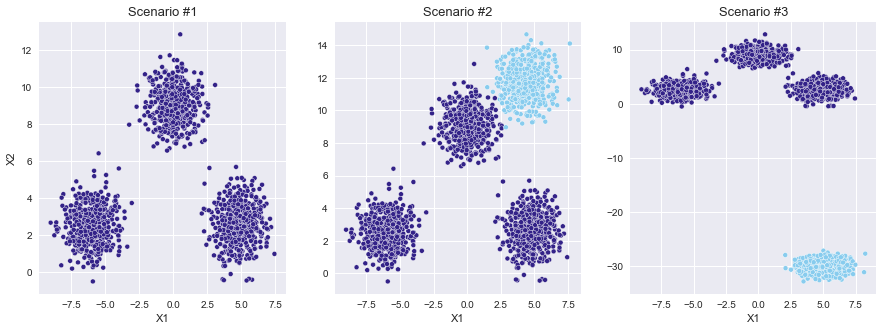

In [45]:
# Plot the three datasets:
_ = plt.figure(figsize=(15, 5))

_ = plt.subplot(131)
_ = sns.scatterplot(x=blobs_1[0][:, 0], y=blobs_1[0][:, 1], color=colors[0], size=2, legend=False)
_ = plt.title('Scenario #1', fontsize=13)
_ = plt.xlabel('X1')
_ = plt.ylabel('X2')

_ = plt.subplot(132)
xx = np.where(blobs_2[1] != 3)[0]
_ = sns.scatterplot(x=blobs_2[0][xx, 0], y=blobs_2[0][xx, 1], color=colors[0], size=2, legend=False)
xx = np.where(blobs_2[1] == 3)[0]
_ = sns.scatterplot(x=blobs_2[0][xx, 0], y=blobs_2[0][xx, 1], color=colors[1], size=2, legend=False)
_ = plt.title('Scenario #2', fontsize=13)
_ = plt.xlabel('X1')
# _ = plt.ylabel('X2')

_ = plt.subplot(133)
xx = np.where(blobs_3[1] != 3)[0]
_ = sns.scatterplot(x=blobs_3[0][xx, 0], y=blobs_3[0][xx, 1], color=colors[0], size=2, legend=False)
xx = np.where(blobs_3[1] == 3)[0]
_ = sns.scatterplot(x=blobs_3[0][xx, 0], y=blobs_3[0][xx, 1], color=colors[1], size=2, legend=False)
_ = plt.title('Scenario #3', fontsize=13)
_ = plt.xlabel('X1')
# _ = plt.ylabel('X2')

In [46]:
# Plot the three datasets:

plots = []

plot = figure(title='Scenario #1', x_axis_label='X1', y_axis_label='X2', plot_height=300, plot_width=300)
plot.circle(blobs_1[0][:, 0], blobs_1[0][:, 1], color=colors[0])
plots.append(plot)

plot = figure(title='Scenario #2', x_axis_label='X1', y_axis_label='X2', plot_height=300, plot_width=300)
xx = np.where(blobs_2[1] != 3)[0]
plot.circle(blobs_2[0][xx, 0], blobs_2[0][xx, 1], color=colors[0])
xx = np.where(blobs_2[1] == 3)[0]
plot.circle(blobs_2[0][xx, 0], blobs_2[0][xx, 1], color=colors[1])
plots.append(plot)

plot = figure(title='Scenario #3', x_axis_label='X1', y_axis_label='X2', plot_height=300, plot_width=300)
xx = np.where(blobs_3[1] != 3)[0]
plot.circle(blobs_3[0][xx, 0], blobs_3[0][xx, 1], color=colors[0])
xx = np.where(blobs_3[1] == 3)[0]
plot.circle(blobs_3[0][xx, 0], blobs_3[0][xx, 1], color=colors[1])
plots.append(plot)

layout = gridplot(plots, ncols=3)
show(layout)

### How do we choose the number of clusters?

I will explore four options for determining the number of clusters:
1. The inertia parameter and the so-called "elbow plot"
2. The silhouette coefficient
3. The gap statistic
4. The prediction strength

#### Option 1: The "Elbow Plot"

This first option makes use of the inertia parameter, which is calculated as part of the
k-Means algorithm itself. The inertia parameter is the sum of the square of the distance
of each point from its cluster center:

[insert image here?]

#### Option 2:

#### Option 3:

#### Option 4: The Prediction Strength

I read about the prediction strength in [the book]. I found code for implementing this
option in [an article on Towards Data Science](https://towardsdatascience.com/prediction-strength-a-simple-yet-relatively-unknown-way-to-evaluate-clustering-2e5eaf56643).

In [47]:
def kmeans_find_num_clusters(X, method='elbow', n_clust_min=2, n_clust_max=20, inc=1):

    if method in ['elbow', 'silhouette', 'pred_strength']:
        # For the silhouette coefficient method, mininum number of clusters must be 2:
        if method == 'silhouette':
            n_clust_min = max(n_clust_min, 2)

        # Initialize lists for different parameters:
        results_list = []

        # Create train and test sets for the prediction strength:
        if method == 'pred_strength':
            np.random.seed(42)
            msk = np.random.rand(X.shape[0]) < 0.8
            X_train, X_test = X[msk, :], X[~msk, :]

        for jj in range(n_clust_min, n_clust_max+1, inc):
            # Run k-Means:
            model = cluster.KMeans(n_clusters=jj, random_state=42, verbose=0)
            model.fit(X)

            if method == 'elbow':
                # Save the inertia statistic from the clustering algorithm:
                results_list.append(model.inertia_)

            elif method == 'silhouette':
                # Calculate and save the Silhouette score for the current clustering:
                silh_coef = metrics.silhouette_score(X, model.labels_, metric='euclidean')
                results_list.append(silh_coef)

            elif method == 'pred_strength':
                # Calculate prediction strength:
                model_train = cluster.KMeans(n_clusters=jj, random_state=42).fit(X_train)
                model_test = cluster.KMeans(n_clusters=jj, random_state=42).fit(X_test)
                pred_str = get_prediction_strength(jj, model_train.cluster_centers_, X_test, model_test.labels_)
                results_list.append(pred_str)

        if method == 'elbow':
            # Use elbow of inertia curve as initial guess for optimal cluster number:
            num_clusters = np.arange(n_clust_min, n_clust_max + 1, inc)
            sec_derivative = np.zeros(len(results_list))
            for ii in range(1, len(results_list) - 1):
                sec_derivative[ii] = results_list[ii+1] + results_list[ii-1] - 2 * results_list[ii]
            best_clust_num = num_clusters[1 + np.argmax(sec_derivative[1:-1])]

        elif method == 'silhouette':
            best_clust_num = np.nanargmax(np.array(results_list)) + n_clust_min

        elif method == 'pred_strength':
            xx = np.where(np.array(results_list) > 0.8)[0]
            best_clust_num = xx[-1] + n_clust_min

    elif method == 'gap_stat':
        optimalK = OptimalK()
        best_clust_num = optimalK(X, cluster_array=np.arange(n_clust_min, n_clust_max+1, inc))
        results_list = optimalK.gap_df["gap_value"].to_list()

    return results_list, best_clust_num

In [48]:
# Set parameters to use below:
n_clusters_min = 1
n_clusters_max = 10

### k-Mean Clustering for Scenario #1

In [49]:
# Load the data and scale it:
X, y = blobs_1
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_elbow, best_clust_num = kmeans_find_num_clusters(X, method='elbow',
                                                              n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by inertia): {}'.format(best_clust_num))

results_list_silh, best_clust_num = kmeans_find_num_clusters(X, method='silhouette',
                                                             n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by silhouette coefficient): {}'.format(best_clust_num))

results_list_gap, best_clust_num = kmeans_find_num_clusters(X, method='gap_stat',
                                                            n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by gap statistic): {}'.format(best_clust_num))

# results_list_predstr, best_clust_num = kmeans_find_num_clusters(X, method='pred_strength',
#                                                                 n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
# print('Best cluster number (by prediction strength): {}'.format(best_clust_num))

Best cluster number (by inertia): 3
Best cluster number (by silhouette coefficient): 3
Best cluster number (by gap statistic): 5


In [50]:
# Functions for plotting results:

def plot_clusters(X, cluster_labels, title):
    plot = figure(title=title, x_axis_label='X1', y_axis_label='X2', plot_height=400, plot_width=400)
    for ii in np.unique(cluster_labels):
        xx = np.where(cluster_labels == ii)[0]
        plot.circle(X[xx, 0], X[xx, 1], color=colors[ii])
    return plot

def plot_param_by_clust_num(results_list, num_clusters, metric='Inertia', best_clust_num=3):
    plot = figure(x_axis_label='Number of Clusters', y_axis_label=metric, plot_height=300, plot_width=300)
    plot.line(num_clusters, results_list)
    plot.circle(num_clusters, results_list)
    plot.add_layout(Span(location=best_clust_num, dimension='height', line_dash='dashed'))
    return plot

In [51]:
# Plot the results:

model = cluster.KMeans(n_clusters=3, random_state=42, verbose=0)
model.fit(X)

show(plot_clusters(X, model.labels_, 'k-Means - Scenario #1 (with 3 clusters)'))

In [52]:
plots = []
num_clusters = np.arange(n_clusters_min, n_clusters_max+1, 1)

plots.append(plot_param_by_clust_num(results_list_elbow, num_clusters, 'Inertia', 3))

plots.append(plot_param_by_clust_num(results_list_silh, num_clusters[1:], 'Silhouette Coefficient', 3))

plots.append(plot_param_by_clust_num(results_list_gap, num_clusters, 'Gap Statistic', 3))

# plots.append(plot_param_by_clust_num(results_list_predstr, num_clusters, 'Prediction Strength', 3))

layout = gridplot(plots, ncols=2)
show(layout)

### k-Mean Clustering for Scenario #2

In [53]:
# Load the data and scale it:
X, y = blobs_2
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_elbow, best_clust_num = kmeans_find_num_clusters(X, method='elbow',
                                                              n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by inertia): {}'.format(best_clust_num))

results_list_silh, best_clust_num = kmeans_find_num_clusters(X, method='silhouette',
                                                             n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by silhouette coefficient): {}'.format(best_clust_num))

results_list_gap, best_clust_num = kmeans_find_num_clusters(X, method='gap_stat',
                                                            n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by gap statistic): {}'.format(best_clust_num))

# results_list_predstr, best_clust_num = kmeans_find_num_clusters(X, method='pred_strength',
#                                                                 n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
# print('Best cluster number (by prediction strength): {}'.format(best_clust_num))

Best cluster number (by inertia): 3
Best cluster number (by silhouette coefficient): 4
Best cluster number (by gap statistic): 4


In [54]:
# Plot the results:

plots = []

model = cluster.KMeans(n_clusters=3, random_state=42, verbose=0)
model.fit(X)

plots.append(plot_clusters(X, model.labels_, 'k-Means - Scenario #2 (with 3 clusters)'))

model = cluster.KMeans(n_clusters=4, random_state=42, verbose=0)
model.fit(X)

plots.append(plot_clusters(X, model.labels_, 'k-Means - Scenario #2 (with 4 clusters)'))

layout = gridplot(plots, ncols=2)
show(layout)

In [55]:
plots = []
num_clusters = np.arange(n_clusters_min, n_clusters_max+1, 1)

plots.append(plot_param_by_clust_num(results_list_elbow, num_clusters, 'Inertia', 4))

plots.append(plot_param_by_clust_num(results_list_silh, num_clusters[1:], 'Silhouette Coefficient', 4))

plots.append(plot_param_by_clust_num(results_list_gap, num_clusters, 'Gap Statistic', 4))

# plots.append(plot_param_by_clust_num(results_list_predstr, num_clusters, 'Prediction Strength', 4))

layout = gridplot(plots, ncols=2)
show(layout)

### k-Means Clustering for Scenario #3

In [56]:
# Load the data and scale it:
X, y = blobs_3
X = StandardScaler().fit_transform(X)

# Find the best cluster number:
results_list_elbow, best_clust_num = kmeans_find_num_clusters(X, method='elbow',
                                                              n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by inertia): {}'.format(best_clust_num))

results_list_silh, best_clust_num = kmeans_find_num_clusters(X, method='silhouette',
                                                             n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by silhouette coefficient): {}'.format(best_clust_num))

results_list_gap, best_clust_num = kmeans_find_num_clusters(X, method='gap_stat',
                                                            n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
print('Best cluster number (by gap statistic): {}'.format(best_clust_num))

# results_list_predstr, best_clust_num = kmeans_find_num_clusters(X, method='pred_strength',
#                                                                 n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
# print('Best cluster number (by prediction strength): {}'.format(best_clust_num))

Best cluster number (by inertia): 2
Best cluster number (by silhouette coefficient): 4
Best cluster number (by gap statistic): 4


In [57]:
# Plot the results:

plots = []

model = cluster.KMeans(n_clusters=4, random_state=42, verbose=0)
model.fit(X)

plots.append(plot_clusters(X, model.labels_, 'k-Means - Scenario #2 (with 4 clusters)'))

model = cluster.KMeans(n_clusters=5, random_state=42, verbose=0)
model.fit(X)

plots.append(plot_clusters(X, model.labels_, 'k-Means - Scenario #3 (with 5 clusters)'))

layout = gridplot(plots, ncols=2)
show(layout)

In [58]:
plots = []
num_clusters = np.arange(n_clusters_min, n_clusters_max+1, 1)

plots.append(plot_param_by_clust_num(results_list_elbow, num_clusters, 'Inertia', 4))

plots.append(plot_param_by_clust_num(results_list_silh, num_clusters[1:], 'Silhouette Coefficient', 4))

plots.append(plot_param_by_clust_num(results_list_gap, num_clusters, 'Gap Statistic', 4))

# plots.append(plot_param_by_clust_num(results_list_predstr, num_clusters, 'Prediction Strength', 4))

layout = gridplot(plots, ncols=2)
show(layout)

### A Note About the Gap Statistic

When running this code multiple times, I found that the gap statistic sometimes gave
different results for the same exact dataset.

I will illustrate this here:

In [59]:
# Run the gap statistic calculation multiple times for the three blobs dataset:
for jj in range(10):
    results_list_gap, best_clust_num = kmeans_find_num_clusters(X, method='gap_stat',
                                                                n_clust_min=n_clusters_min, n_clust_max=n_clusters_max)
    print('Best cluster number (by gap statistic): {}'.format(best_clust_num))

Best cluster number (by gap statistic): 7
Best cluster number (by gap statistic): 7
Best cluster number (by gap statistic): 10
Best cluster number (by gap statistic): 4
Best cluster number (by gap statistic): 10
Best cluster number (by gap statistic): 9
Best cluster number (by gap statistic): 7
Best cluster number (by gap statistic): 9
Best cluster number (by gap statistic): 7
Best cluster number (by gap statistic): 9


You can see in the plot above of the gap statistic versus the number of clusters, that in Scenario #3, the gap statistic is fairly similar from 4 clusters to 10 clusters. Depending on the random sampling that the algorithm does, there is enough randomness to make small changes in the gap statistic that sometimes 4 clusters is chosen and sometime it's 10 clusters.

### How Long Does it Take to Run Each Technique?

In [60]:
print('Time to run one iteration of k-Means (if you already know the number of clusters:)')
%timeit cluster.KMeans(n_clusters=3, random_state=42, verbose=0).fit(X)

print('\nTime to run k-Means with the Elbow method:')
%timeit results = kmeans_find_num_clusters(X, method='elbow', n_clust_min=2, n_clust_max=10)

print('\nTime to run k-Means with the Silhouette method:')
# %timeit results = kmeans_find_num_clusters(X, method='silhouette', n_clust_min=2, n_clust_max=10)

print('\nTime to run k-Means with the Gap Statistic method:')
# %timeit results = kmeans_find_num_clusters(X, method='gap_stat', n_clust_min=2, n_clust_max=10)

# print('\nTime to run k-Means with the Prediction Strength method:')
# %timeit results = kmeans_find_num_clusters(X, method='pred_strength', n_clust_min=2, n_clust_max=3)

Time to run one iteration of k-Means (if you already know the number of clusters:)
68.7 ms ± 31.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Time to run k-Means with the Elbow method:
463 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Time to run k-Means with the Silhouette method:

Time to run k-Means with the Gap Statistic method:


### Reviewing the Results

I explored here four techniques for automatically detecting the number of clusters in a dataset when using k-Means clustering. For each test, I used three or four circular blobs of points, where the points are distributed normally within the blobs.

The two techniques that consistently gave good results were the silhouette coefficient and the prediction strength. I will briefly summarize how each of the four techniques performed here.

#### Option 1: The "Elbow Plot"

The issue with the "elbow plot" is that when looking at it by eye, it may be easy to identify the "elbow" (at least in the test cases here), but it seems difficult to accurately pick-up the "elbow" location in an automated way.

#### Option 2: The Silhouette Coefficient

In the test cases here, using the number of clusters that gives the maximum silhouette coefficient seems to give accurate results, without slowing down the runtime as much as the prediction strength.

One potential downside of the silhouette coefficient is that it is undefined if there is only one cluster, so there is no way to consider the option of one cluster compared to two or more clusters. So, if you had a dataset that actually would be best clustered as just a single cluster, this method would not be able to pick-up on this.

#### Option 3: The Gap Statistic

This option sometimes gave different results, even for the "easy" case of Scenario #1, with three well-separated clusters. This lack of consistency is definitely a strike against this technique, even though it does seem to be the fastest one.

#### Option 4: The Prediction Strength

This option is very slow, at least using the code I found to calculate this metric. Perhaps, it could be made a bit more efficient, but it is currently very expensive to check a large number of cluster numbers.

Also, the technique relies on choosing a threshold, which has been reported to be 0.8, for selecting the best number of clusters. In the "easy" case of Scenario #1 above, the selection of 6 clusters gives a prediction strength very close to 0.8. It would be interesting to know how strongly this threshold holds up in many different real-world scenarios.

### Is There Another Option?

The common downside to all of these techniques is that they all require running k-Means multiple times, each time checking how good the clustering is. Is there an algorithm that figures out the number of clusters on its own, as part of the fitting process. I will explore this in a subsequent post!